In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Tue Jan 23 15:11:48 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.dalle_encoder import Encoder
from model.latent.vqvae_latent import Latent
from model.decoder.dalle_decoder import Decoder
from model.no_module import NoModule

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.n_latents = 256
hp.z_dim = 512

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), NoModule(**hp), Latent(**hp), NoModule(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 18.6689453125
encoder.encoder 18.6689453125
prior 0.0
latent 0.0
latent.bottle 0.0
quantizer 0.0
decoder 9.954113006591797
decoder.decoder 9.954113006591797
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.21-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 100000, model_list, optimizer_list)

total 1463016
-rw-rw-r-- 1 scpark scpark        40  1월 23 15:11 events.out.tfevents.1705990238.GPUSVR11
-rw-rw-r-- 1 scpark scpark     30084  1월 23 15:11 events.out.tfevents.1705990250.GPUSVR11
-rw-rw-r-- 1 scpark scpark  90710013  1월 23 15:11 save_100000
-rw-rw-r-- 1 scpark scpark        40  1월 22 12:32 events.out.tfevents.1705886957.GPUSVR11
-rw-rw-r-- 1 scpark scpark   6079875  1월 22 12:32 events.out.tfevents.1705886963.GPUSVR11
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 12:12 save_90000
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 11:51 save_80000
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 11:30 save_70000
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 11:10 save_60000
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 10:50 save_50000
-rw-rw-r-- 1 scpark scpark  90709569  1월 22 10:29 save_40000
-rw-rw-r-- 1 scpark scpark   4812905  1월 21 22:45 events.out.tfevents.1705838827.GPUSVR11
-rw-rw-r-- 1 scpark scpark  90709185  1월 21 22:09 save_30000
-rw-rw-r-- 1 scpark scpark  90709185  1월 21 21:

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

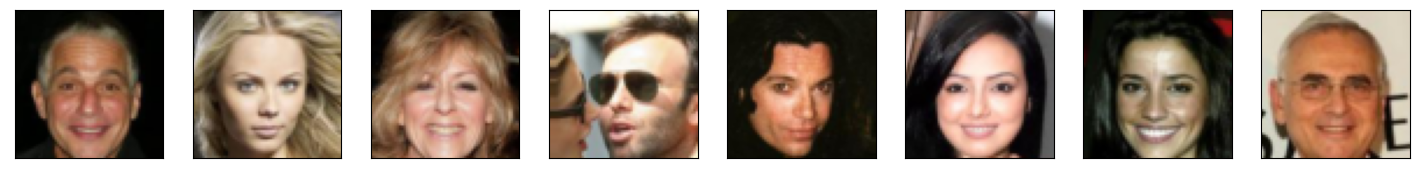

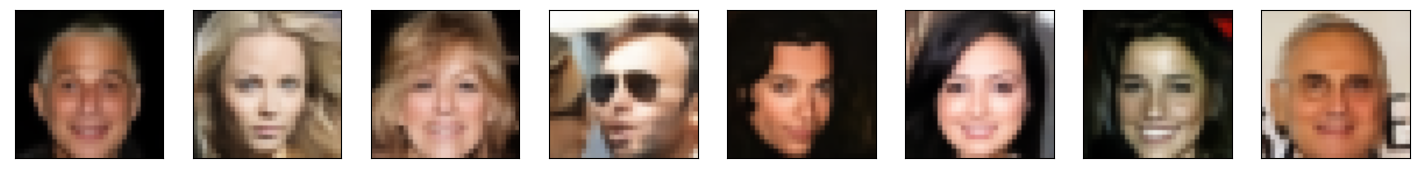

110001
commit_loss 0.00032630469650030136
recon_loss 0.002777930349111557
110002
commit_loss 0.00030577878351323307
recon_loss 0.002767978236079216
110003
commit_loss 0.00031903840135782957
recon_loss 0.0026492930483072996
110004
commit_loss 0.0003257361240684986
recon_loss 0.0027573234401643276
110005
commit_loss 0.00031600281363353133
recon_loss 0.0027158986777067184
110006
commit_loss 0.0003167054383084178
recon_loss 0.0026370191480964422
110007
commit_loss 0.00034197315108031034
recon_loss 0.002706870436668396
110008
commit_loss 0.00030815228819847107
recon_loss 0.002697508316487074
110009
commit_loss 0.00030694453744217753
recon_loss 0.002658504992723465
110010
commit_loss 0.00033262025681324303
recon_loss 0.002792324870824814
110011
commit_loss 0.0003297720104455948
recon_loss 0.0026764858048409224
110012
commit_loss 0.0003069138037972152
recon_loss 0.0026270817033946514
110013
commit_loss 0.00037503382191061974
recon_loss 0.002750085201114416
110014
commit_loss 0.000312155054416

110112
commit_loss 0.00033301018993370235
recon_loss 0.0028212168253958225
110113
commit_loss 0.00031401641899719834
recon_loss 0.0027297164779156446
110114
commit_loss 0.00032484051189385355
recon_loss 0.0027164719067513943
110115
commit_loss 0.00032151470077224076
recon_loss 0.0027804658748209476
110116
commit_loss 0.0003183918306604028
recon_loss 0.0027303616516292095
110117
commit_loss 0.0003254023613408208
recon_loss 0.0027285413816571236
110118
commit_loss 0.0003247015119995922
recon_loss 0.0026886712294071913
110119
commit_loss 0.0003179292834829539
recon_loss 0.0026296828873455524
110120
commit_loss 0.0003091788094025105
recon_loss 0.0027205869555473328
110121
commit_loss 0.0003083118936046958
recon_loss 0.0026774161960929632
110122
commit_loss 0.00030949083156883717
recon_loss 0.0026396256871521473
110123
commit_loss 0.000313284108415246
recon_loss 0.0027475240640342236
110124
commit_loss 0.00031468342058360577
recon_loss 0.0027100220322608948
110125
commit_loss 0.000318109028

110223
commit_loss 0.00033562531461939216
recon_loss 0.002792066428810358
110224
commit_loss 0.0003198040067218244
recon_loss 0.002692951587960124
110225
commit_loss 0.0003237467026337981
recon_loss 0.0027147536166012287
110226
commit_loss 0.000318307604175061
recon_loss 0.00270507438108325
110227
commit_loss 0.00032441294752061367
recon_loss 0.0027636014856398106
110228
commit_loss 0.00030949123902246356
recon_loss 0.0026628568302839994
110229
commit_loss 0.0003130700788460672
recon_loss 0.0026685071643441916
110230
commit_loss 0.0003159853513352573
recon_loss 0.0027256289031356573
110231
commit_loss 0.00031129264971241355
recon_loss 0.002647833665832877
110232
commit_loss 0.000326281413435936
recon_loss 0.0027545278426259756
110233
commit_loss 0.00030254831654019654
recon_loss 0.0025618320796638727
110234
commit_loss 0.00030731537844985723
recon_loss 0.0027161017060279846
110235
commit_loss 0.00030836931546218693
recon_loss 0.0027403701096773148
110236
commit_loss 0.00030071541550569

110334
commit_loss 0.00031011144164949656
recon_loss 0.002728402614593506
110335
commit_loss 0.00037483847700059414
recon_loss 0.0027428362518548965
110336
commit_loss 0.00031436324934475124
recon_loss 0.002671604510396719
110337
commit_loss 0.0003110215184278786
recon_loss 0.002719169482588768
110338
commit_loss 0.0003542293852660805
recon_loss 0.0027156691066920757
110339
commit_loss 0.0003005782491527498
recon_loss 0.002614520490169525
110340
commit_loss 0.00033190494286827743
recon_loss 0.002672791015356779
110341
commit_loss 0.00031600630609318614
recon_loss 0.002709789201617241
110342
commit_loss 0.00030709849670529366
recon_loss 0.002643842250108719
110343
commit_loss 0.0003241895465180278
recon_loss 0.0027130148373544216
110344
commit_loss 0.00030251365387812257
recon_loss 0.0025832103565335274
110345
commit_loss 0.0003032617678400129
recon_loss 0.002657275414094329
110346
commit_loss 0.0003216873446945101
recon_loss 0.002684143139049411
110347
commit_loss 0.0003058771835640073

110445
commit_loss 0.0003126617521047592
recon_loss 0.0027133189141750336
110446
commit_loss 0.0003058367583435029
recon_loss 0.002661054488271475
110447
commit_loss 0.00031788047635927796
recon_loss 0.0028172205202281475
110448
commit_loss 0.00029992341296747327
recon_loss 0.002641716506332159
110449
commit_loss 0.0003011990920640528
recon_loss 0.002573169069364667
110450
commit_loss 0.0003171179268974811
recon_loss 0.0026703595649451017
110451
commit_loss 0.0003193850861862302
recon_loss 0.0026648796629160643
110452
commit_loss 0.00031851042876951396
recon_loss 0.002659635152667761
110453
commit_loss 0.000321860279655084
recon_loss 0.002716055139899254
110454
commit_loss 0.00032866577384993434
recon_loss 0.0027680862694978714
110455
commit_loss 0.0003159577026963234
recon_loss 0.0026384983211755753
110456
commit_loss 0.0003261985257267952
recon_loss 0.0027395072393119335
110457
commit_loss 0.00031639228109270334
recon_loss 0.0027051824145019054
110458
commit_loss 0.000323328276863321

110556
commit_loss 0.0003293419140391052
recon_loss 0.0027487347833812237
110557
commit_loss 0.00032471324084326625
recon_loss 0.002763299038633704
110558
commit_loss 0.0003181761421728879
recon_loss 0.0027362112887203693
110559
commit_loss 0.0003199379425495863
recon_loss 0.0026936978101730347
110560
commit_loss 0.00032153440406545997
recon_loss 0.0027907895855605602
110561
commit_loss 0.0003084334312006831
recon_loss 0.002654376206919551
110562
commit_loss 0.00032147247111424804
recon_loss 0.0027299902867525816
110563
commit_loss 0.0003154715523123741
recon_loss 0.002601444721221924
110564
commit_loss 0.0003252324240747839
recon_loss 0.0027300480287522078
110565
commit_loss 0.0003156179445795715
recon_loss 0.0026380110066384077
110566
commit_loss 0.00031083248904906213
recon_loss 0.0025838399305939674
110567
commit_loss 0.00030813709599897265
recon_loss 0.0026363227516412735
110568
commit_loss 0.00031541765201836824
recon_loss 0.002667537657544017
110569
commit_loss 0.000302690925309

110667
commit_loss 0.00031467838562093675
recon_loss 0.00270737218670547
110668
commit_loss 0.0003398174012545496
recon_loss 0.0028919577598571777
110669
commit_loss 0.0003366426099091768
recon_loss 0.0027672857977449894
110670
commit_loss 0.0003293628105893731
recon_loss 0.0027046024333685637
110671
commit_loss 0.00031008035875856876
recon_loss 0.0026461330708116293
110672
commit_loss 0.00032891324372030795
recon_loss 0.002635553479194641
110673
commit_loss 0.0003135649021714926
recon_loss 0.0027490153443068266
110674
commit_loss 0.00032355007715523243
recon_loss 0.0027413852512836456
110675
commit_loss 0.00032488914439454675
recon_loss 0.0027392625343054533
110676
commit_loss 0.0003205098328180611
recon_loss 0.0026829843409359455
110677
commit_loss 0.0003170616691932082
recon_loss 0.002576922532171011
110678
commit_loss 0.00031160557409748435
recon_loss 0.0026123279239982367
110679
commit_loss 0.00031703696004115045
recon_loss 0.0026202581357210875
110680
commit_loss 0.00030748004792

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            def get_entropy(zi):
                # (N, L)
                zi_onehot = F.one_hot(zi, num_classes=hp.n_latents)
                # (L)
                probs = zi_onehot.sum(dim=0) / len(zi_onehot)
                entropy = torch.sum(-probs * (torch.log(torch.clamp(probs, 1e-8)) - np.log(2)))
                return entropy

            entropy = get_entropy(data['zi']).item()
            writer.add_scalar('entropy', entropy, step)
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')